# Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
user_df = pd.read_csv('../data/users.csv')
user_df['record_date'] = pd.to_datetime(user_df['record_date'], utc=True)
user_df.head()

,user_id,birth_year,record_date,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals
0,user_0,1989,2019-01-13 05:15:15.599466+00:00,STANDARD,1.0,1.0,3,0,0
1,user_1,1975,2019-01-29 03:38:46.676876+00:00,STANDARD,NaN,NaN,21,0,0
2,user_2,1987,2019-01-18 19:17:31.229096+00:00,STANDARD,0.0,0.0,21,0,0
3,user_3,1994,2019-01-15 18:47:56.723104+00:00,STANDARD,1.0,0.0,0,0,0
4,user_4,1985,2019-01-11 00:36:46.673673+00:00,STANDARD,NaN,NaN,2,0,0


In [3]:
trans_df = pd.read_csv('../data/trans.csv')
trans_df['record_date'] = pd.to_datetime(trans_df['record_date'], utc=True)
trans_df.head()

,record_date,user_id,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id
0,2019-04-03 03:34:21.784000+00:00,user_898,NaN,4.55,transaction_0,COMPLETED,type_0
1,2020-03-19 06:15:59.537000+00:00,user_1652,FALSE,15.50,transaction_1,COMPLETED,type_1
2,2020-03-18 18:53:41.323000+00:00,user_1652,FALSE,43.40,transaction_2,COMPLETED,type_1
3,2020-03-22 14:20:01.513000+00:00,user_1652,NaN,10043.01,transaction_3,COMPLETED,type_0
4,2020-03-22 05:42:50.316000+00:00,user_5509,FALSE,43.81,transaction_4,COMPLETED,type_1


# Data Cleaning

In [4]:
day1 = '2020-01-01'
cut_day = '2020-03-31'
last_day = trans_df['record_date'].max()
last_day

Timestamp('2020-05-14 21:38:40.194000+0000', tz='UTC')

In [5]:
user_df['user_days'] = (last_day - user_df['record_date']).dt.days
user_df = user_df.set_index(['user_id']).sort_values('record_date', ascending=True)
user_df.head()

,birth_year,record_date,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,user_days
user_id,,,,,,,,,
user_356,1984,2019-01-01 08:42:24.799709+00:00,STANDARD,NaN,NaN,0,0,0,499
user_719,1991,2019-01-02 02:01:39.771058+00:00,STANDARD,1.0,1.0,3,0,0,498
user_172,1995,2019-01-02 03:20:41.549118+00:00,STANDARD,1.0,1.0,14,0,0,498
user_375,1983,2019-01-02 07:02:50.830419+00:00,STANDARD,NaN,NaN,0,0,0,498
user_182,1981,2019-01-02 14:10:18.593231+00:00,STANDARD,1.0,1.0,0,0,0,498


## Transaction

In [6]:
trans_hist = trans_df.loc[trans_df.record_date < day1, :]
trans_active = trans_df.loc[(trans_df.record_date <= cut_day) & (trans_df.record_date >= day1),:]
trans_no_churn = trans_df.loc[(trans_df.record_date > cut_day) & (trans_df.user_id.isin(trans_active.user_id)),:]
churn_rate = (len(trans_active.user_id.unique()) - len(trans_no_churn.user_id.unique())) * 100 / \
              len(trans_active.user_id.unique())

print('Number of current users before 2020-01-01 is {}'.format(len(trans_hist.user_id.unique())))
print('Number of current active users from 2020-01-01 to 2020-03-31 is {}'.format(len(trans_active.user_id.unique())))
print('Number of active users after 2020-03-31 is {}'.format(len(trans_no_churn.user_id.unique())))
print('Customer churn rate after 2020-03-31 is {:.2f}%'.format(churn_rate))

Number of current users before 2020-01-01 is 9372
Number of current active users from 2020-01-01 to 2020-03-31 is 6685
Number of active users after 2020-03-31 is 5132
Customer churn rate after 2020-03-31 is 23.23%


### Transaction History

Transactions before 1/1/2020

In [7]:
trans_hist = trans_hist.set_index(['user_id']).sort_values('record_date', ascending=True)
trans_hist['record_date'] = pd.to_datetime(trans_hist['record_date'], utc=True)
trans_hist['next_trans'] = trans_hist['record_date'].groupby("user_id").shift(-1)
trans_hist['day_diff'] = (trans_hist['next_trans'] - trans_hist['record_date']).dt.days
trans_hist = trans_hist.drop('next_trans', axis=1)
trans_hist.head()

,record_date,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id,day_diff
user_id,,,,,,,
user_375,2019-01-02 07:09:41.673000+00:00,NaN,5.00,transaction_594289,COMPLETED,type_7,180.0
user_657,2019-01-02 16:32:22.172000+00:00,NaN,5.00,transaction_9393,COMPLETED,type_7,46.0
user_46,2019-01-02 20:36:25.868000+00:00,NaN,42.55,transaction_545571,COMPLETED,type_4,24.0
user_472,2019-01-02 21:35:06.239000+00:00,NaN,8.51,transaction_546053,FAILED,type_4,0.0
user_472,2019-01-02 21:38:32.797000+00:00,NaN,8.51,transaction_545576,COMPLETED,type_4,0.0


In [8]:
trans_hist_monthly = trans_hist.groupby(['user_id', trans_hist['record_date'].dt.year, \
                                         trans_hist['record_date'].dt.month]).\
        agg({'trans_id':'count', 'trans_amount':['mean'], 'day_diff':['mean']}).fillna(0)
trans_hist_monthly.columns=['count','trans_amount','day_diff']
trans_hist_monthly.head()

count  trans_amount  day_diff
user_id record_date record_date                               
user_0  2019        1               14     11.291429  1.000000
                    2               11     61.998182  2.272727
                    3               24     30.975000  1.291667
                    4                6    155.366667  3.833333
                    5               16      6.630625  1.687500

### Active Transactions

Transactions after 1/1/2020

In [9]:
trans_active = trans_active.set_index(['user_id']).sort_values('record_date', ascending=True)
trans_active['record_date'] = pd.to_datetime(trans_active['record_date'], utc=True)
trans_active['next_trans'] = trans_active['record_date'].groupby("user_id").shift(-1)
trans_active['day_diff'] = (trans_active['next_trans'] - trans_active['record_date']).dt.days
trans_active = trans_active.drop('next_trans', axis=1)
trans_active['last_trans_day'] = (trans_active.record_date.max() - \
                                  trans_active.groupby('user_id')['record_date'].transform('max')).dt.days
trans_active.head()

,record_date,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id,day_diff,last_trans_day
user_id,,,,,,,,
user_8791,2020-01-01 00:00:06.928000+00:00,FALSE,42.55,transaction_813354,COMPLETED,type_3,NaN,89
user_1796,2020-01-01 00:00:28.954000+00:00,FALSE,1.24,transaction_814235,COMPLETED,type_1,0.0,13
user_1009,2020-01-01 00:00:32.144000+00:00,NaN,20.00,transaction_122257,COMPLETED,type_4,0.0,0
user_7030,2020-01-01 00:01:01.018000+00:00,NaN,0.09,transaction_814420,COMPLETED,type_0,2.0,8
user_9844,2020-01-01 00:02:09.645000+00:00,NaN,872.39,transaction_773006,COMPLETED,type_4,0.0,0


In [10]:
trans_active_monthly = trans_active.groupby(['user_id', trans_active['record_date'].dt.year,
                                   trans_active['record_date'].dt.month]).\
       agg({'trans_id':'count', 'trans_amount':['mean'], 'day_diff':['mean'], 'last_trans_day':['max']}).fillna(0)
trans_active_monthly.columns=['count','trans_amount','day_diff', 'last_trans_day']
trans_active_monthly.head()

count  trans_amount   day_diff  \
user_id record_date record_date                                   
user_0  2020        1                7      2.331429   1.428571   
                    2               18     60.060556   1.388889   
                    3               16     14.227500   1.466667   
user_1  2020        1                2    125.400000  20.000000   
                    2                6     65.975000   0.200000   

                                 last_trans_day  
user_id record_date record_date                  
user_0  2020        1                         1  
                    2                         1  
                    3                         1  
user_1  2020        1                        35  
                    2                        35

### Transaction Difference

In [11]:
trans_diff = trans_df.set_index(['user_id']).sort_values('record_date', ascending=True)
trans_diff['record_date'] = pd.to_datetime(trans_diff['record_date'], utc=True)
trans_diff['next_trans'] = trans_diff['record_date'].groupby("user_id").shift(-1)
trans_diff['day_diff'] = (trans_diff['next_trans'] - trans_diff['record_date']).dt.days
trans_diff = trans_diff.drop('next_trans', axis=1)
trans_diff.head()

,record_date,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id,day_diff
user_id,,,,,,,
user_375,2019-01-02 07:09:41.673000+00:00,NaN,5.00,transaction_594289,COMPLETED,type_7,180.0
user_657,2019-01-02 16:32:22.172000+00:00,NaN,5.00,transaction_9393,COMPLETED,type_7,46.0
user_46,2019-01-02 20:36:25.868000+00:00,NaN,42.55,transaction_545571,COMPLETED,type_4,24.0
user_472,2019-01-02 21:35:06.239000+00:00,NaN,8.51,transaction_546053,FAILED,type_4,0.0
user_472,2019-01-02 21:38:32.797000+00:00,NaN,8.51,transaction_545576,COMPLETED,type_4,0.0


In [12]:
trans_diff_monthly = trans_diff.groupby(['user_id', trans_diff['record_date'].dt.year, \
                                         trans_diff['record_date'].dt.month]).\
        agg({'trans_id':'count', 'trans_amount':['mean'], 'day_diff':['mean']}).fillna(0)
trans_diff_monthly.columns=['count','trans_amount','day_diff']
trans_diff_monthly.head()

count  trans_amount  day_diff
user_id record_date record_date                               
user_0  2019        1               14     11.291429  1.000000
                    2               11     61.998182  2.272727
                    3               24     30.975000  1.291667
                    4                6    155.366667  3.833333
                    5               16      6.630625  1.687500

In [13]:
trans_diff2 = trans_diff_monthly.diff().dropna()
trans_diff2.head()

count  trans_amount  day_diff
user_id record_date record_date                               
user_0  2019        2             -3.0     50.706753  1.272727
                    3             13.0    -31.023182 -0.981061
                    4            -18.0    124.391667  2.541667
                    5             10.0   -148.736042 -2.145833
                    6             10.0     20.362837 -0.649038

In [14]:
diff_hist = trans_diff2.xs(2019, level=1, drop_level=False)
diff_hist.head()

count  trans_amount  day_diff
user_id record_date record_date                               
user_0  2019        2             -3.0     50.706753  1.272727
                    3             13.0    -31.023182 -0.981061
                    4            -18.0    124.391667  2.541667
                    5             10.0   -148.736042 -2.145833
                    6             10.0     20.362837 -0.649038

In [15]:
diff_active = trans_diff2.xs(2020, level=1, drop_level=False)
diff_active.head()

count  trans_amount  day_diff
user_id record_date record_date                               
user_0  2020        1             -3.0     -7.476571 -1.971429
                    2             11.0     57.729127 -0.039683
                    3             -2.0    -45.833056  0.298611
                    4             28.0     55.796591 -1.278409
                    5            -43.0    -62.484091 -0.409091

### Group by users

In [16]:
trans_hist_user = trans_hist_monthly.groupby('user_id').\
        agg({'count':['mean'], 'trans_amount':['mean'], 'day_diff':['mean']})
trans_hist_user.columns=['count', 'trans_amount', 'day_diff']
trans_hist_user.head()

,count,trans_amount,day_diff
user_id,,,
user_0,16.250000,36.641226,2.661244
user_1,8.111111,50.640900,4.630866
user_10,21.250000,51.293883,1.226983
user_100,5.111111,168.960776,13.064815
user_1000,5.750000,554.454292,7.608333


In [17]:
trans_active_user = trans_active_monthly.groupby('user_id').\
        agg({'count':['mean'], 'trans_amount':['mean'], 'day_diff':['mean'], 'last_trans_day':['max']})
trans_active_user.columns=['count', 'trans_amount', 'day_diff', 'last_trans_day']
trans_active_user.head()

,count,trans_amount,day_diff,last_trans_day
user_id,,,,
user_0,13.666667,25.539828,1.428042,1
user_1,4.000000,95.687500,10.100000,35
user_10,22.000000,37.997273,1.150219,3
user_100,9.333333,121.732222,1.925926,10
user_1002,14.666667,141.985667,1.083333,16


In [18]:
diff_hist_user = diff_hist.groupby('user_id').\
        agg({'count':['mean'], 'trans_amount':['mean'], 'day_diff':['mean']})
diff_hist_user.columns=['count', 'trans_amount', 'day_diff']
diff_hist_user.head()

,count,trans_amount,day_diff
user_id,,,
user_0,-0.363636,-0.134857,0.218182
user_1,0.555556,1.276667,0.685185
user_10,2.416667,-2.368083,0.033333
user_100,-0.111111,21.812778,5.722222
user_1000,-0.750000,-13.558750,-0.333333


In [19]:
diff_active_jan = diff_active.xs(1, level=2, drop_level=True).reset_index()\
        [['user_id', 'count', 'trans_amount', 'day_diff']]
diff_active_feb = diff_active.xs(2, level=2, drop_level=True).reset_index()\
        [['user_id', 'count', 'trans_amount', 'day_diff']]
diff_active_mar = diff_active.xs(3, level=2, drop_level=True).reset_index()\
        [['user_id', 'count', 'trans_amount', 'day_diff']]
diff_active_user = pd.merge(diff_active_jan, diff_active_feb, how='outer', on='user_id', suffixes=('_jan', ''))\
        .fillna(0)
diff_active_user = pd.merge(diff_active_user, diff_active_mar, how='outer', on='user_id', suffixes=('_feb', '_mar'))\
        .fillna(0)
diff_active_user.head()

,user_id,count_jan,trans_amount_jan,day_diff_jan,count_feb,trans_amount_feb,day_diff_feb,count_mar,trans_amount_mar,day_diff_mar
0,user_0,-3.0,-7.476571,-1.971429,11.0,57.729127,-0.039683,-2.0,-45.833056,0.298611
1,user_1,-4.0,106.370000,13.833333,4.0,-59.425000,-19.800000,0.0,0.000000,0.000000
2,user_10,-3.0,-25.570813,0.087500,-13.0,48.075444,0.575658,-2.0,-22.999690,0.207430
3,user_100,4.0,-152.831667,-51.666667,12.0,-4.475000,0.111111,-14.0,55.956667,4.555556
4,user_1002,16.0,-21.962500,-6.600000,-5.0,-112.776333,0.950000,-6.0,113.054667,-0.600000


### Combine History and Active

In [20]:
trans_user = pd.merge(trans_hist_user, trans_active_user, how='right', on='user_id', \
                      suffixes=('_before','_now')).fillna(0)
trans_user = pd.merge(trans_user, user_df[['user_days']], how='left', on='user_id', suffixes=('','')).fillna(0)
trans_user['churn'] = 1
trans_user.loc[trans_user.index.isin(trans_no_churn.user_id),'churn'] = 0
trans_user.head()

,count_before,trans_amount_before,day_diff_before,count_now,trans_amount_now,day_diff_now,last_trans_day,user_days,churn
user_id,,,,,,,,,
user_0,16.250000,36.641226,2.661244,13.666667,25.539828,1.428042,1,487,0
user_1,8.111111,50.640900,4.630866,4.000000,95.687500,10.100000,35,471,1
user_10,21.250000,51.293883,1.226983,22.000000,37.997273,1.150219,3,496,0
user_100,5.111111,168.960776,13.064815,9.333333,121.732222,1.925926,10,485,0
user_1002,4.800000,223.950238,9.563095,14.666667,141.985667,1.083333,16,487,1


In [21]:
diff_user = pd.merge(diff_hist_user, diff_active_user, how='right', on='user_id').fillna(0)
diff_user = diff_user.set_index(['user_id'])
diff_user['churn'] = 1
diff_user.loc[diff_user.index.isin(trans_no_churn.user_id),'churn'] = 0
diff_user.head()

,count,trans_amount,day_diff,count_jan,trans_amount_jan,day_diff_jan,count_feb,trans_amount_feb,day_diff_feb,count_mar,trans_amount_mar,day_diff_mar,churn
user_id,,,,,,,,,,,,,
user_0,-0.363636,-0.134857,0.218182,-3.0,-7.476571,-1.971429,11.0,57.729127,-0.039683,-2.0,-45.833056,0.298611,0
user_1,0.555556,1.276667,0.685185,-4.0,106.370000,13.833333,4.0,-59.425000,-19.800000,0.0,0.000000,0.000000,1
user_10,2.416667,-2.368083,0.033333,-3.0,-25.570813,0.087500,-13.0,48.075444,0.575658,-2.0,-22.999690,0.207430,0
user_100,-0.111111,21.812778,5.722222,4.0,-152.831667,-51.666667,12.0,-4.475000,0.111111,-14.0,55.956667,4.555556,0
user_1002,-1.000000,14.183607,0.578846,16.0,-21.962500,-6.600000,-5.0,-112.776333,0.950000,-6.0,113.054667,-0.600000,1


# Data Analysis

## Transaction

In [22]:
trans_user.describe()

,count_before,trans_amount_before,day_diff_before,count_now,trans_amount_now,day_diff_now,last_trans_day,user_days,churn
count,6686.000000,6.686000e+03,6686.000000,6686.000000,6.686000e+03,6686.000000,6686.000000,6686.000000,6686.000000
mean,12.923735,1.161719e+05,10.419469,14.689251,1.606347e+05,4.449907,16.218068,382.090787,0.232276
std,16.379109,8.452236e+06,13.559621,23.375344,1.225485e+07,5.853142,21.502549,61.810130,0.422316
min,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000,0.000000,254.000000,0.000000
25%,4.000000,1.520825e+01,2.597265,3.000000,1.256783e+01,0.604930,1.000000,329.000000,0.000000
50%,7.800000,3.177511e+01,6.451124,7.000000,2.763036e+01,2.286681,6.000000,379.000000,0.000000
75%,15.714286,6.764828e+01,13.000000,16.000000,6.730100e+01,5.833333,24.000000,433.000000,0.000000
max,245.250000,6.899640e+08,161.000000,258.666667,1.000000e+09,43.000000,89.000000,498.000000,1.000000


In [23]:
trans_user.loc[trans_user['churn'] == 0].describe()

,count_before,trans_amount_before,day_diff_before,count_now,trans_amount_now,day_diff_now,last_trans_day,user_days,churn
count,5133.000000,5.133000e+03,5133.000000,5133.000000,5.133000e+03,5133.000000,5133.000000,5133.000000,5133.0
mean,14.583403,1.512849e+05,9.625244,17.633158,2.091936e+05,4.354710,11.004091,381.447886,0.0
std,17.752402,9.646430e+06,12.645993,25.731523,1.398634e+07,5.524381,17.025009,61.909155,0.0
min,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000,0.000000,254.000000,0.0
25%,4.636364,1.587395e+01,2.445902,4.000000,1.369008e+01,0.800261,0.000000,329.000000,0.0
50%,9.000000,3.184419e+01,5.782540,9.000000,2.879538e+01,2.368376,4.000000,378.000000,0.0
75%,17.777778,6.789110e+01,11.753125,20.000000,6.724059e+01,5.666667,14.000000,433.000000,0.0
max,245.250000,6.899640e+08,161.000000,258.666667,1.000000e+09,43.000000,89.000000,498.000000,0.0


In [24]:
trans_user.loc[trans_user['churn'] == 1].describe()

,count_before,trans_amount_before,day_diff_before,count_now,trans_amount_now,day_diff_now,last_trans_day,user_days,churn
count,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.0
mean,7.438175,116.096728,13.044553,4.959004,136.906438,4.764553,33.451384,384.215712,1.0
std,8.615892,1371.274109,15.942699,6.384052,1239.936457,6.820629,25.416563,61.453699,0.0
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,256.000000,1.0
25%,2.400000,12.235000,3.418075,1.333333,8.900000,0.000000,12.000000,332.000000,1.0
50%,5.000000,31.590071,8.805000,3.000000,24.422500,1.876679,27.000000,381.000000,1.0
75%,9.500000,65.930833,16.673401,6.000000,67.355455,6.666667,52.000000,433.000000,1.0
max,99.600000,52990.929361,142.000000,71.000000,46659.077500,42.500000,89.000000,498.000000,1.0


## Transaction Difference

In [25]:
diff_user.describe()

,count,trans_amount,day_diff,count_jan,trans_amount_jan,day_diff_jan,count_feb,trans_amount_feb,day_diff_feb,count_mar,trans_amount_mar,day_diff_mar,churn
count,6712.000000,6.712000e+03,6712.000000,6712.000000,6.712000e+03,6712.000000,6712.000000,6.712000e+03,6712.000000,6712.000000,6.712000e+03,6712.000000,6712.000000
mean,1.009300,1.086005e+05,10.111522,-0.352354,-7.440391e+05,-4.103637,0.460816,2.718391e+04,-5.608114,1.862634,3.082853e+05,-8.310250,0.235399
std,5.467461,8.427034e+06,32.923489,15.226290,5.896687e+07,28.159722,15.295362,2.350718e+06,29.538111,15.806031,2.756431e+07,33.273665,0.424280
min,-110.000000,-7.500912e+04,-16.527273,-195.000000,-4.829748e+09,-371.000000,-148.000000,-1.020409e+07,-381.000000,-147.000000,-1.923077e+08,-447.000000,0.000000
25%,-0.285714,-4.892500e+00,0.114286,-3.000000,-9.865354e+00,-2.000000,-2.000000,-8.957212e+00,-2.139881,-2.000000,-1.035980e+01,-4.000000,0.000000
50%,0.333333,2.265575e-01,0.813657,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,1.875000,5.959167e+00,5.067045,2.000000,8.335133e+00,0.960550,2.000000,8.903611e+00,0.530100,4.000000,1.042187e+01,0.282828,0.000000
max,124.000000,6.899639e+08,440.000000,185.000000,1.020407e+07,122.333333,211.000000,1.923077e+08,86.777778,201.000000,2.250000e+09,59.375000,1.000000


In [26]:
diff_user.loc[diff_user['churn'] == 0].describe()

,count,trans_amount,day_diff,count_jan,trans_amount_jan,day_diff_jan,count_feb,trans_amount_feb,day_diff_feb,count_mar,trans_amount_mar,day_diff_mar,churn
count,5132.000000,5.132000e+03,5132.000000,5132.000000,5.132000e+03,5132.000000,5132.000000,5.132000e+03,5132.000000,5132.000000,5.132000e+03,5132.000000,5132.0
mean,1.368201,1.420334e+05,6.773964,-0.205378,-9.731162e+05,-1.971597,0.693492,3.555112e+04,-2.718465,2.630164,4.032106e+05,-5.089605,0.0
std,5.713727,9.637319e+06,25.293054,16.583562,6.743572e+07,23.389464,17.019191,2.688340e+06,22.811485,17.548519,3.152327e+07,27.081115,0.0
min,-110.000000,-7.500912e+04,-16.527273,-195.000000,-4.829748e+09,-329.625000,-148.000000,-1.020409e+07,-365.250000,-147.000000,-1.923077e+08,-390.000000,0.0
25%,-0.181818,-4.600510e+00,0.076013,-4.000000,-1.138822e+01,-1.373611,-3.000000,-1.130675e+01,-1.555556,-3.000000,-1.234595e+01,-2.541253,0.0
50%,0.500000,3.371066e-01,0.514983,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,-0.001600,0.0
75%,2.250000,5.699941e+00,2.823333,4.000000,1.020894e+01,1.299548,4.000000,1.066110e+01,0.946310,7.000000,1.397154e+01,0.744561,0.0
max,124.000000,6.899639e+08,394.000000,185.000000,1.020407e+07,122.333333,211.000000,1.923077e+08,86.777778,201.000000,2.250000e+09,59.375000,0.0


In [27]:
diff_user.loc[diff_user['churn'] == 1].describe()

,count,trans_amount,day_diff,count_jan,trans_amount_jan,day_diff_jan,count_feb,trans_amount_feb,day_diff_feb,count_mar,trans_amount_mar,day_diff_mar,churn
count,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,1580.0
mean,-0.156445,7.061334,20.952249,-0.829747,26.593443,-11.028720,-0.294937,6.374155,-14.993986,-0.630380,-41.566861,-18.771234,1.0
std,4.380166,252.344519,48.727184,9.559891,789.489229,39.112388,7.234276,234.181586,43.612366,7.279638,1792.432424,46.681193,0.0
min,-59.000000,-1416.218333,-7.777778,-161.000000,-9057.260000,-371.000000,-92.000000,-4190.335000,-381.000000,-89.000000,-70596.475000,-447.000000,1.0
25%,-0.666667,-5.953099,0.789151,-1.000000,-3.838875,-7.562500,-1.000000,-0.494250,-9.723214,0.000000,-2.124167,-14.000000,1.0
50%,0.000000,0.000000,4.262121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,0.750000,7.225865,16.295536,0.000000,1.025625,0.000000,0.000000,1.200000,0.000000,0.000000,0.000000,0.000000,1.0
max,30.000000,8981.191667,440.000000,75.000000,28031.615000,83.500000,89.000000,3302.110000,39.709677,64.000000,4590.760000,20.000000,1.0


## Pairplot

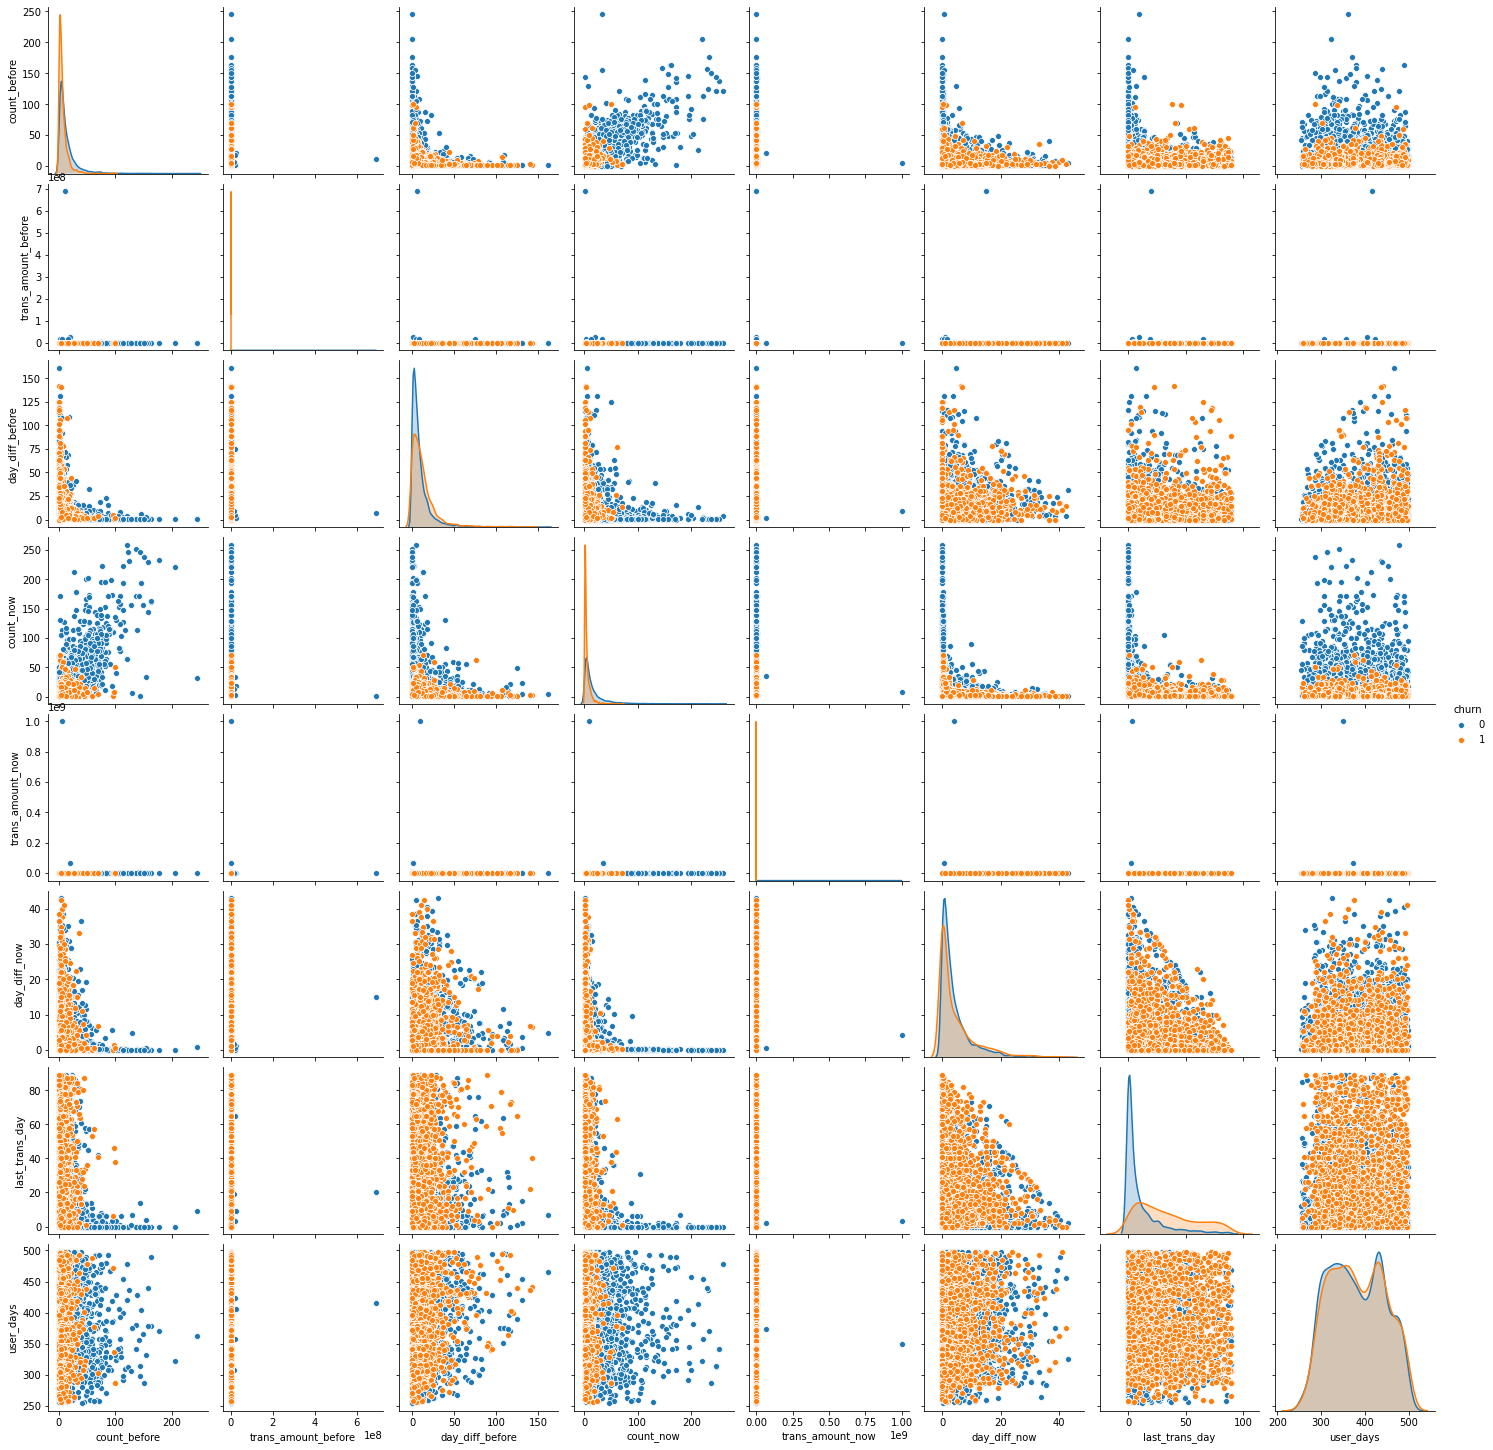

In [28]:
sns.pairplot(trans_user, hue='churn', diag_kind='kde');

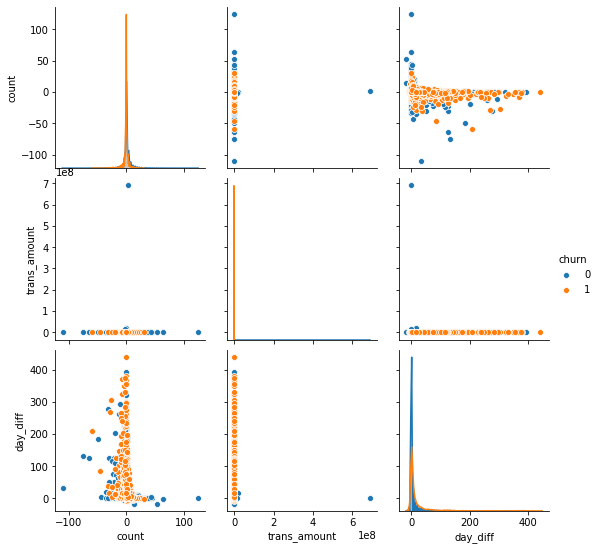

In [29]:
sns.pairplot(diff_user[['count', 'trans_amount', 'day_diff', 'churn']], hue='churn', diag_kind='kde');

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

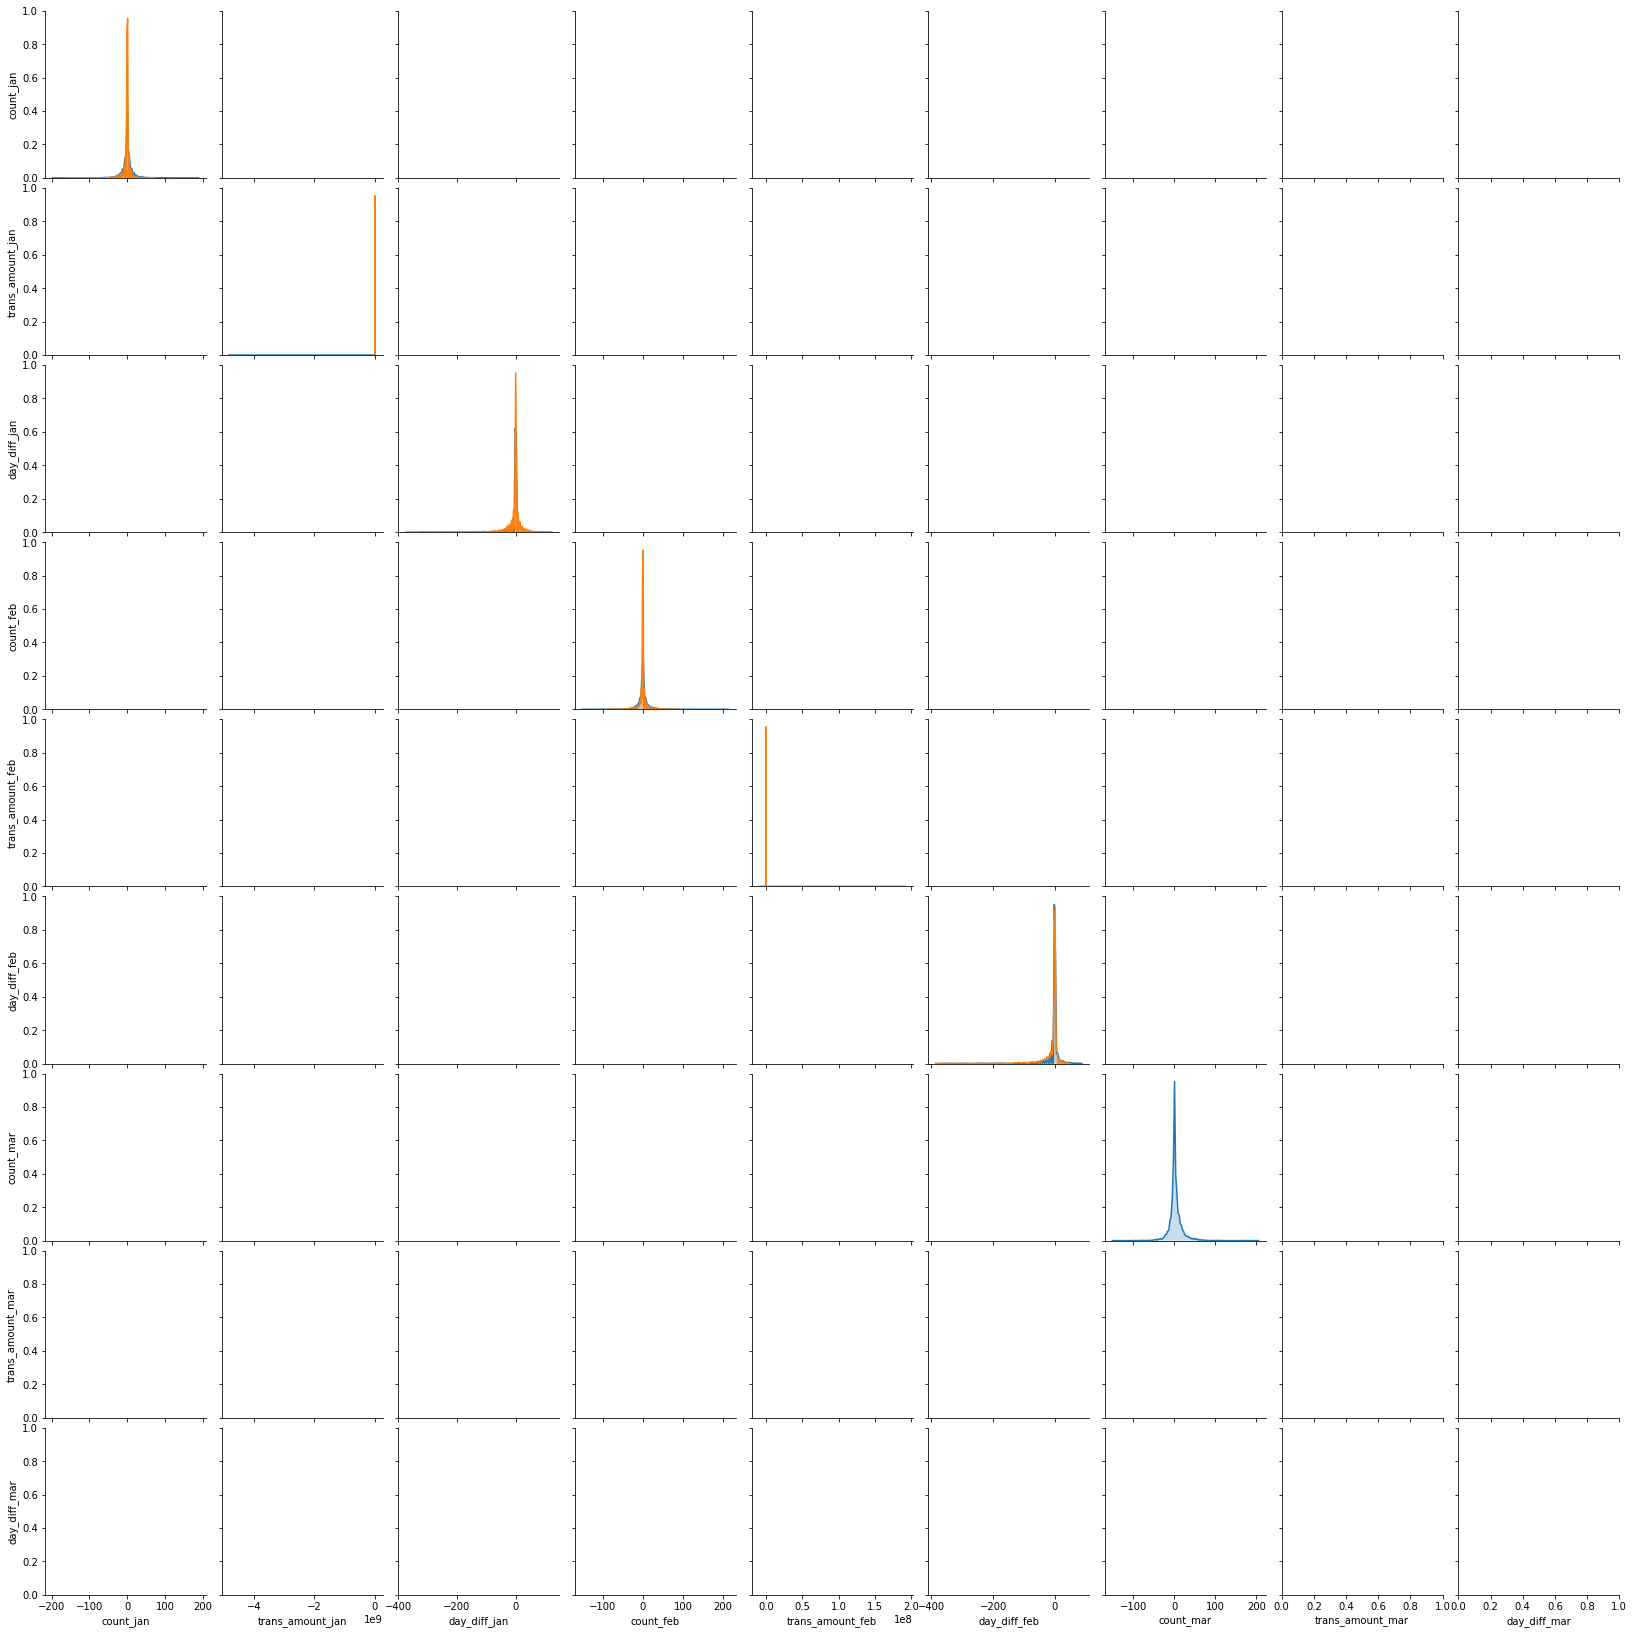

In [30]:
sns.pairplot(diff_user.drop(columns=['count', 'trans_amount', 'day_diff']), hue='churn', diag_kind='kde');

## Boxplot

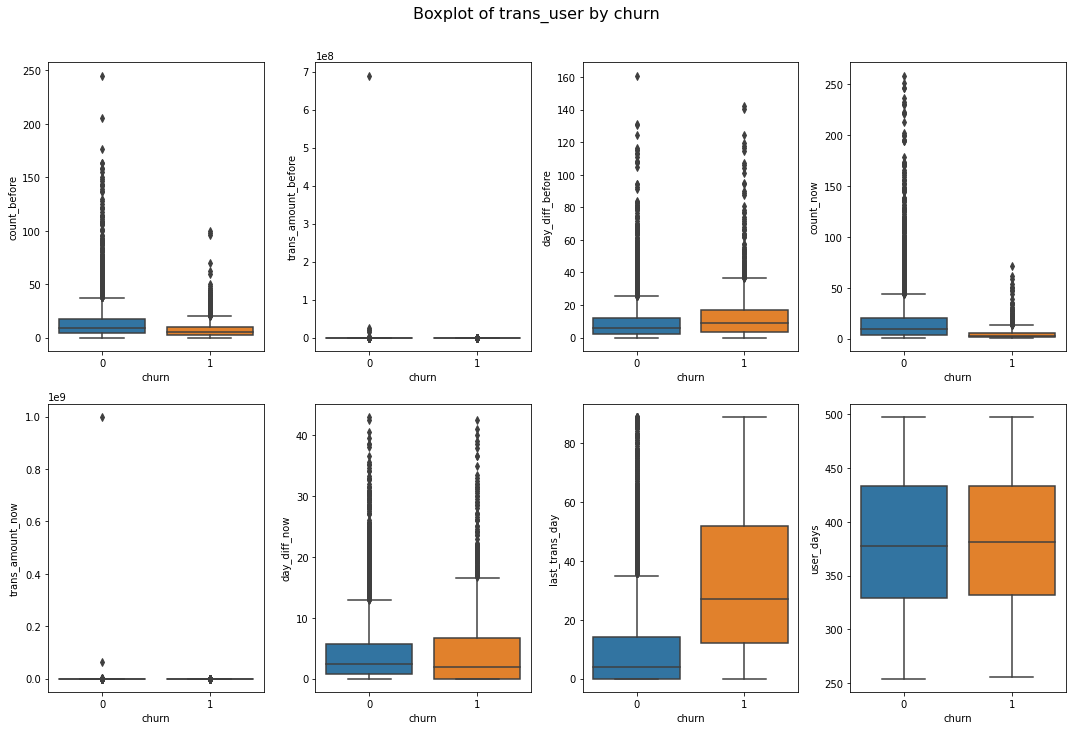

In [31]:
NumCols = trans_user.columns.drop('churn')
fig, ax = plt.subplots(nrows=2,ncols=4, figsize=(15,10))
fig.suptitle('Boxplot of trans_user by churn', y=1.01, fontsize=16)

for i, ax in enumerate(fig.axes):
    if i < len(NumCols):
        sns.boxplot(y=NumCols[i], x='churn', data=trans_user, ax=ax)

fig.tight_layout();

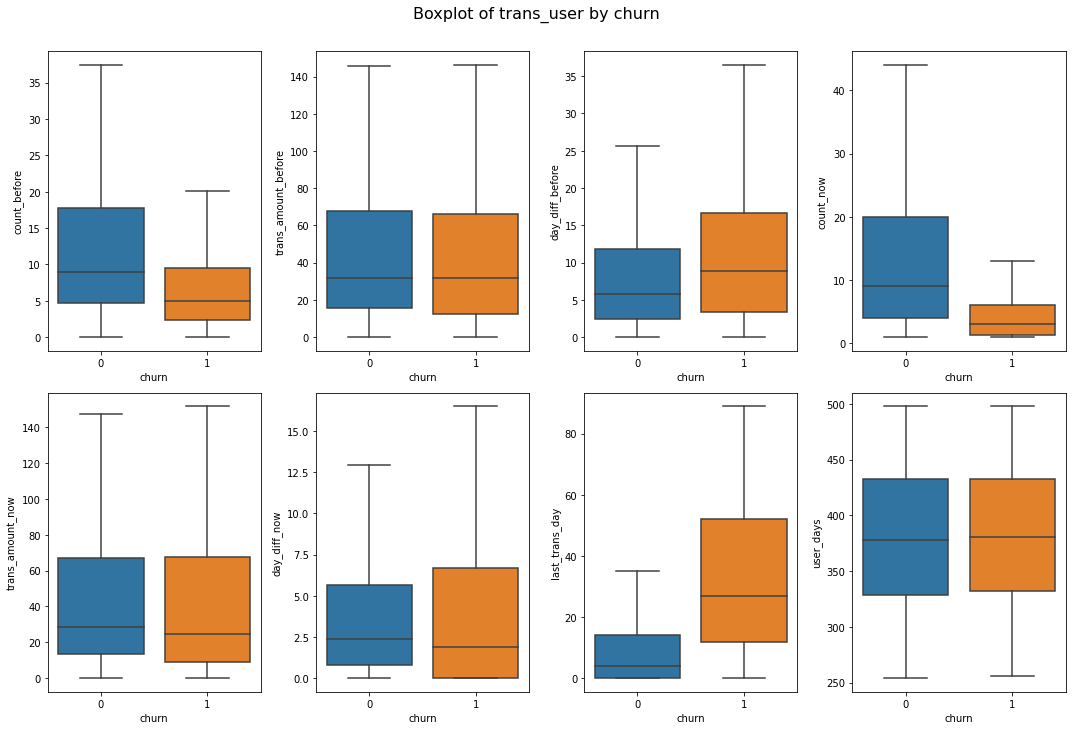

In [32]:
NumCols = trans_user.columns.drop('churn')
fig, ax = plt.subplots(nrows=2,ncols=4, figsize=(15,10))
fig.suptitle('Boxplot of trans_user by churn', y=1.01, fontsize=16)

for i, ax in enumerate(fig.axes):
    if i < len(NumCols):
        sns.boxplot(y=NumCols[i], x='churn', data=trans_user, ax=ax, showfliers=False)

fig.tight_layout();

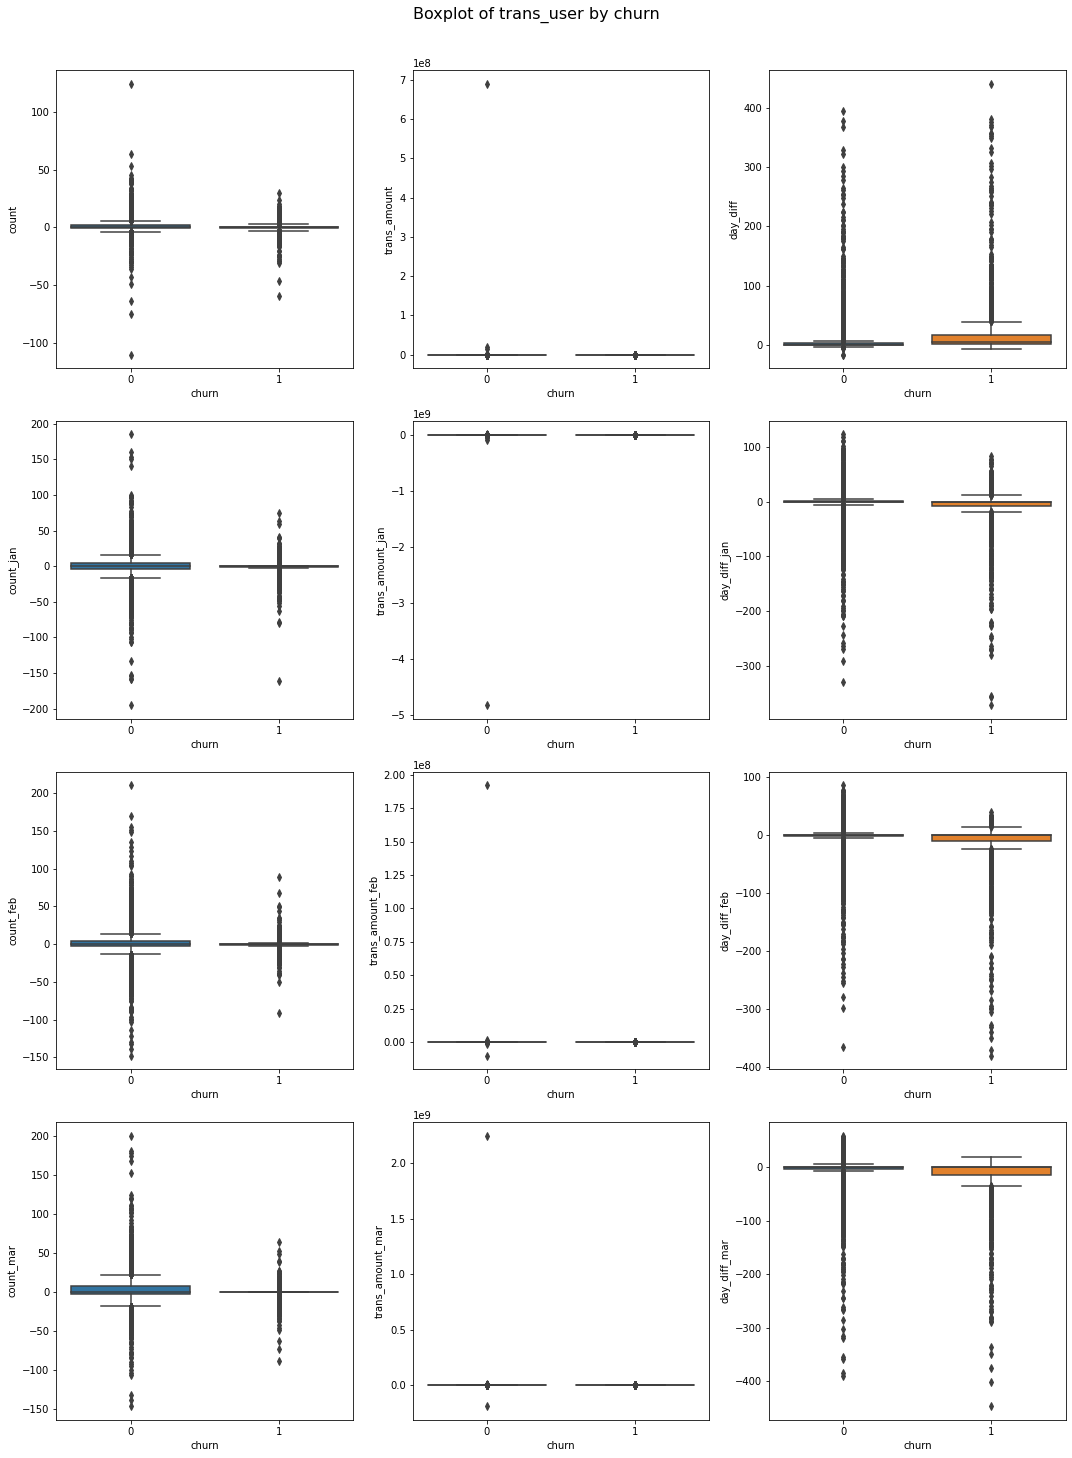

In [33]:
NumCols = diff_user.columns.drop('churn')
fig, ax = plt.subplots(nrows=4,ncols=3, figsize=(15,20))
fig.suptitle('Boxplot of trans_user by churn', y=1.01, fontsize=16)

for i, ax in enumerate(fig.axes):
    if i < len(NumCols):
        sns.boxplot(y=NumCols[i], x='churn', data=diff_user, ax=ax)

fig.tight_layout();

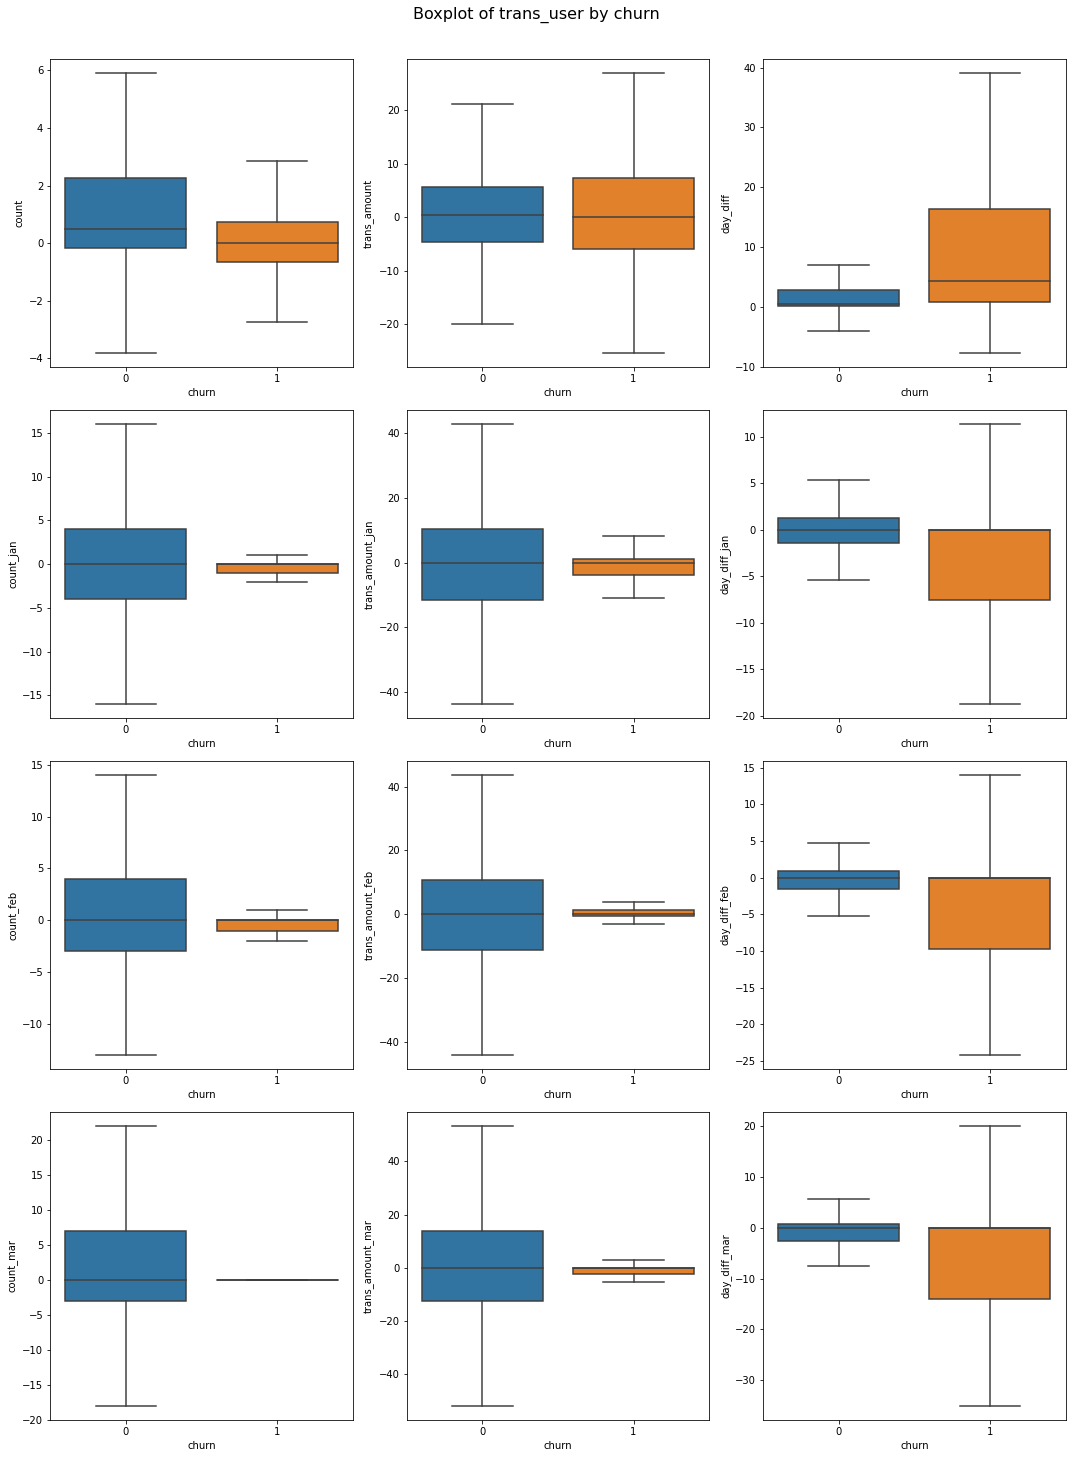

In [34]:
NumCols = diff_user.columns.drop('churn')
fig, ax = plt.subplots(nrows=4,ncols=3, figsize=(15,20))
fig.suptitle('Boxplot of trans_user by churn', y=1.01, fontsize=16)

for i, ax in enumerate(fig.axes):
    if i < len(NumCols):
        sns.boxplot(y=NumCols[i], x='churn', data=diff_user, ax=ax, showfliers=False)

fig.tight_layout();

# Churn Reasons

## User Info

In [35]:
user_info = pd.merge(user_df, trans_user['churn'], how='right', on='user_id')
user_info = user_info.fillna(0)
user_info['record_date'] = pd.to_datetime(user_info['record_date'], utc=True)
user_info['attributes_notifications_marketing_push'] = user_info['attributes_notifications_marketing_push'].astype('category')
user_info['attributes_notifications_marketing_email'] = user_info['attributes_notifications_marketing_email'].astype('category')
user_info['churn'] = user_info['churn'].astype('category')
user_info.head()

,birth_year,record_date,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,user_days,churn
user_id,,,,,,,,,,
user_0,1989,2019-01-13 05:15:15.599466+00:00,STANDARD,1.0,1.0,3,0,0,487,0
user_1,1975,2019-01-29 03:38:46.676876+00:00,STANDARD,0.0,0.0,21,0,0,471,1
user_10,1980,2019-01-04 08:05:15.466282+00:00,STANDARD,1.0,1.0,38,0,0,496,0
user_100,1969,2019-01-15 08:42:17.099386+00:00,STANDARD,0.0,0.0,0,0,0,485,0
user_1002,1976,2019-01-13 01:04:25.771157+00:00,STANDARD,0.0,0.0,14,0,0,487,1


In [36]:
user_info.describe(include='all')

/Users/kongbinxuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,birth_year,record_date,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,user_days,churn
count,6688.000000,6688,6688,6688.0,6688.0,6688.000000,6688.0,6688.0,6688.000000,6688.0
unique,NaN,6686,6,2.0,2.0,NaN,NaN,NaN,NaN,2.0
top,NaN,2019-02-21 22:22:19.321591+00:00,STANDARD,1.0,1.0,NaN,NaN,NaN,NaN,0.0
freq,NaN,2,5927,4276.0,4056.0,NaN,NaN,NaN,NaN,5135.0
first,NaN,2019-01-02 02:01:39.771058+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2019-09-03 04:40:52.979072+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1983.875897,NaN,NaN,NaN,NaN,19.283493,0.0,0.0,382.112889,NaN
std,10.762864,NaN,NaN,NaN,NaN,50.112875,0.0,0.0,61.814294,NaN
min,1934.000000,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,254.000000,NaN
25%,1978.000000,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,329.000000,NaN


In [37]:
user_info.loc[user_info['churn'] == 0].describe(include='all')

/Users/kongbinxuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,birth_year,record_date,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,user_days,churn
count,5135.000000,5135,5135,5135.0,5135.0,5135.000000,5135.0,5135.0,5135.000000,5135.0
unique,NaN,5133,6,2.0,2.0,NaN,NaN,NaN,NaN,1.0
top,NaN,2019-02-21 22:22:19.321591+00:00,STANDARD,1.0,1.0,NaN,NaN,NaN,NaN,0.0
freq,NaN,2,4440,3385.0,3228.0,NaN,NaN,NaN,NaN,5135.0
first,NaN,2019-01-02 02:01:39.771058+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2019-09-03 04:40:52.979072+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1984.204674,NaN,NaN,NaN,NaN,22.194742,0.0,0.0,381.476923,NaN
std,10.353904,NaN,NaN,NaN,NaN,55.680406,0.0,0.0,61.914831,NaN
min,1937.000000,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,254.000000,NaN
25%,1979.000000,NaN,NaN,NaN,NaN,2.000000,0.0,0.0,329.000000,NaN


In [38]:
user_info.loc[user_info['churn'] == 1].describe(include='all')

/Users/kongbinxuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,birth_year,record_date,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,user_days,churn
count,1553.000000,1553,1553,1553.0,1553.0,1553.000000,1553.0,1553.0,1553.000000,1553.0
unique,NaN,1553,3,2.0,2.0,NaN,NaN,NaN,NaN,1.0
top,NaN,2019-04-28 01:44:31.389955+00:00,STANDARD,1.0,1.0,NaN,NaN,NaN,NaN,1.0
freq,NaN,1,1487,891.0,828.0,NaN,NaN,NaN,NaN,1553.0
first,NaN,2019-01-02 19:18:36.481565+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2019-09-01 12:52:54.441012+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1982.788796,NaN,NaN,NaN,NaN,9.657437,0.0,0.0,384.215712,NaN
std,11.955801,NaN,NaN,NaN,NaN,21.064790,0.0,0.0,61.453699,NaN
min,1934.000000,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,256.000000,NaN
25%,1977.000000,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,332.000000,NaN


### Plan

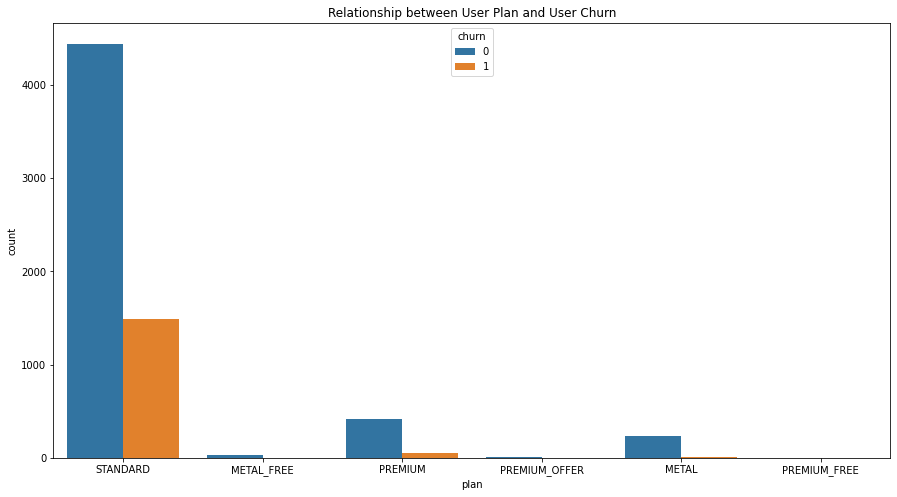

In [39]:
plt.figure(figsize=(15,8))
sns.countplot(x="plan", hue="churn", data=user_info).set_title('Relationship between User Plan and User Churn');

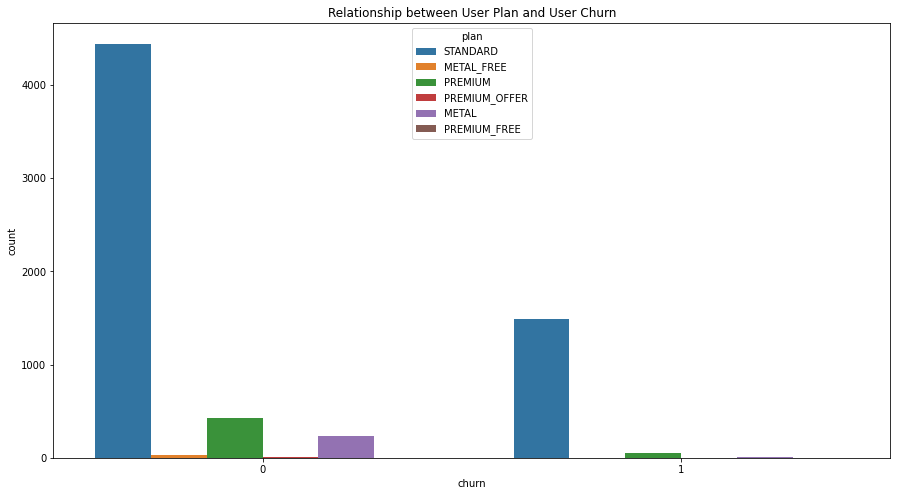

In [40]:
plt.figure(figsize=(15,8))
sns.countplot(x="churn", hue="plan", data=user_info).set_title('Relationship between User Plan and User Churn');

In [41]:
pd.crosstab(user_info['plan'], user_info['churn'])

churn,0,1
plan,,
METAL,238,12
METAL_FREE,27,0
PREMIUM,422,54
PREMIUM_FREE,3,0
PREMIUM_OFFER,5,0
STANDARD,4440,1487


In [42]:
pd.crosstab(user_info['plan'], user_info['churn'], normalize='index')

churn,0,1
plan,,
METAL,0.952000,0.048000
METAL_FREE,1.000000,0.000000
PREMIUM,0.886555,0.113445
PREMIUM_FREE,1.000000,0.000000
PREMIUM_OFFER,1.000000,0.000000
STANDARD,0.749114,0.250886


### Push Notification

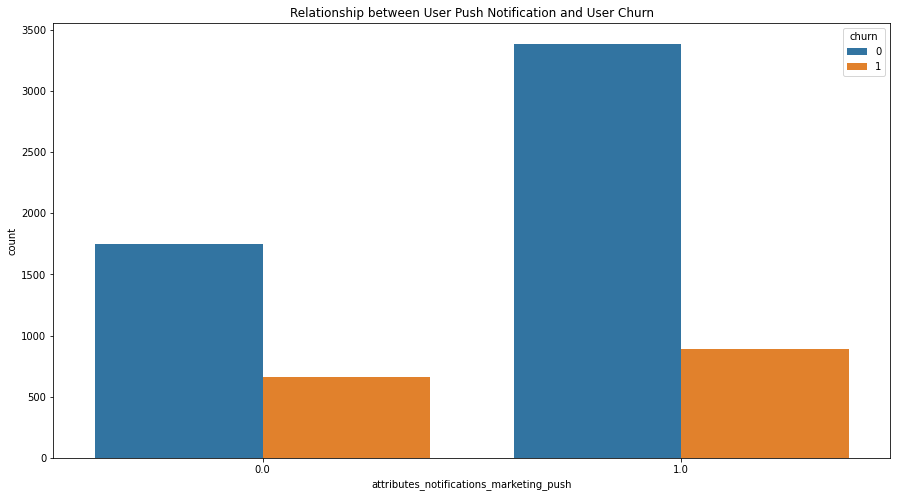

In [43]:
plt.figure(figsize=(15,8))
sns.countplot(x="attributes_notifications_marketing_push", hue="churn", data=user_info).\
        set_title('Relationship between User Push Notification and User Churn');

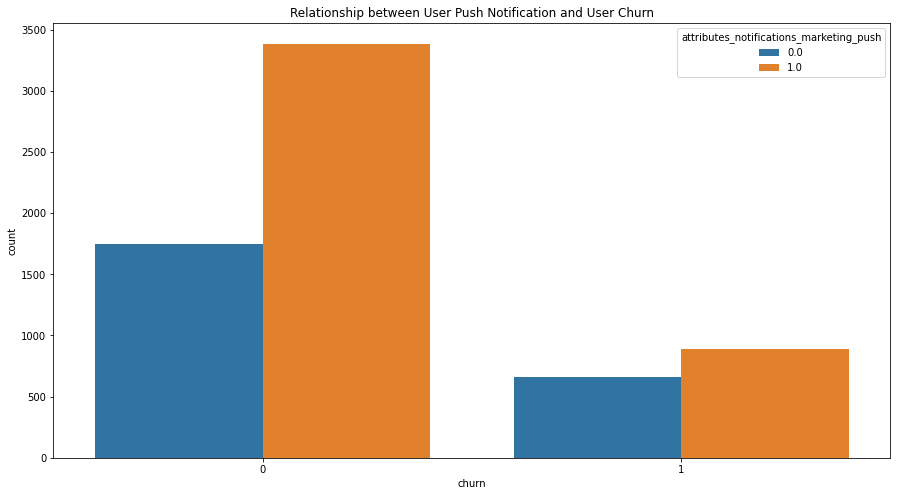

In [44]:
plt.figure(figsize=(15,8))
sns.countplot(x="churn", hue="attributes_notifications_marketing_push", data=user_info).\
        set_title('Relationship between User Push Notification and User Churn');

In [45]:
pd.crosstab(user_info['attributes_notifications_marketing_push'], user_info['churn'])

churn,0,1
attributes_notifications_marketing_push,,
0.0,1750,662
1.0,3385,891


In [46]:
pd.crosstab(user_info['attributes_notifications_marketing_push'], user_info['churn'], normalize='index')

churn,0,1
attributes_notifications_marketing_push,,
0.0,0.725539,0.274461
1.0,0.791628,0.208372


### Email Notification

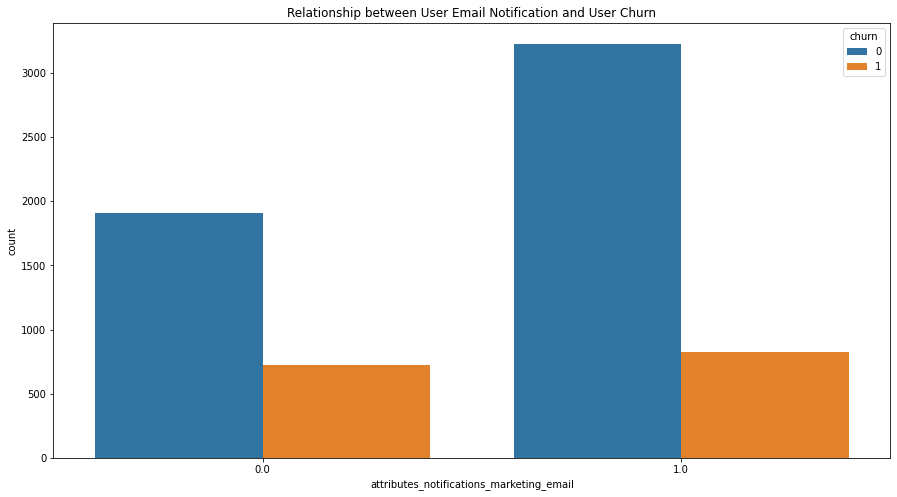

In [47]:
plt.figure(figsize=(15,8))
sns.countplot(x="attributes_notifications_marketing_email", hue="churn", data=user_info).\
        set_title('Relationship between User Email Notification and User Churn');

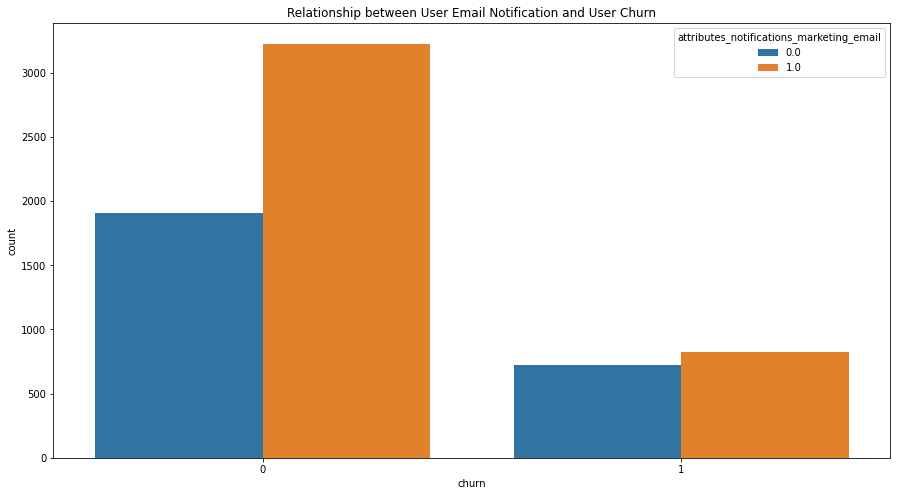

In [48]:
plt.figure(figsize=(15,8))
sns.countplot(x="churn", hue="attributes_notifications_marketing_email", data=user_info).\
        set_title('Relationship between User Email Notification and User Churn');

In [49]:
pd.crosstab(user_info['attributes_notifications_marketing_email'], user_info['churn'])

churn,0,1
attributes_notifications_marketing_email,,
0.0,1907,725
1.0,3228,828


In [50]:
pd.crosstab(user_info['attributes_notifications_marketing_email'], user_info['churn'], normalize='index')

churn,0,1
attributes_notifications_marketing_email,,
0.0,0.724544,0.275456
1.0,0.795858,0.204142


## Notifications

In [51]:
notifs_df = pd.read_csv('../data/notifs.csv')
notifs_df['record_date'] = pd.to_datetime(notifs_df['record_date'], utc=True)
notifs_churn = notifs_df.loc[(notifs_df.user_id.isin(trans_active_user.index)) & (notifs_df.record_date > day1) \
                             & ((notifs_df.record_date <= cut_day)), :]
notifs_churn_users = pd.merge(notifs_churn, trans_user['churn'], how='left', on='user_id')
notifs_churn_users['churn'] = notifs_churn_users['churn'].astype('category')
notifs_churn_users.head()

,reason_id,marketing_channel,notif_status,user_id,record_date,churn
0,reason_00,PUSH,SENT,user_5964,2020-01-01 21:21:18.957271+00:00,0
1,reason_00,PUSH,SENT,user_7760,2020-01-01 23:51:59.561823+00:00,0
2,reason_00,PUSH,SENT,user_2980,2020-01-02 06:47:40.979941+00:00,1
3,reason_00,PUSH,SENT,user_2841,2020-01-02 04:54:58.114277+00:00,0
4,reason_00,PUSH,SENT,user_1426,2020-01-04 07:41:46.755149+00:00,0


In [52]:
notifs_churn_users.describe()

/Users/kongbinxuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,reason_id,marketing_channel,notif_status,user_id,record_date,churn
count,20065,20065,20065,20065,20065,20065.0
unique,9,2,2,6117,20059,2.0
top,reason_10,PUSH,SENT,user_1047,2020-02-21 14:19:02.722591+00:00,0.0
freq,8989,10050,14354,71,2,15533.0
first,NaN,NaN,NaN,NaN,2020-01-01 00:02:42.552985+00:00,NaN
last,NaN,NaN,NaN,NaN,2020-03-30 20:59:13.005745+00:00,NaN


In [53]:
notifs_churn_users.loc[notifs_churn_users['churn'] == 0].describe()

/Users/kongbinxuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,reason_id,marketing_channel,notif_status,user_id,record_date,churn
count,15533,15533,15533,15533,15533,15533.0
unique,9,2,2,4736,15527,1.0
top,reason_10,EMAIL,SENT,user_1047,2020-02-21 14:19:02.722591+00:00,0.0
freq,6978,7939,10950,71,2,15533.0
first,NaN,NaN,NaN,NaN,2020-01-01 00:02:42.552985+00:00,NaN
last,NaN,NaN,NaN,NaN,2020-03-30 20:59:13.005745+00:00,NaN


In [54]:
notifs_churn_users.loc[notifs_churn_users['churn'] == 1].describe()

/Users/kongbinxuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,reason_id,marketing_channel,notif_status,user_id,record_date,churn
count,4532,4532,4532,4532,4532,4532.0
unique,9,2,2,1381,4532,1.0
top,reason_10,PUSH,SENT,user_6650,2020-03-07 18:37:50.147086+00:00,1.0
freq,2011,2456,3404,19,1,4532.0
first,NaN,NaN,NaN,NaN,2020-01-01 00:03:44.764862+00:00,NaN
last,NaN,NaN,NaN,NaN,2020-03-30 13:56:29.406341+00:00,NaN


### Notification Reason

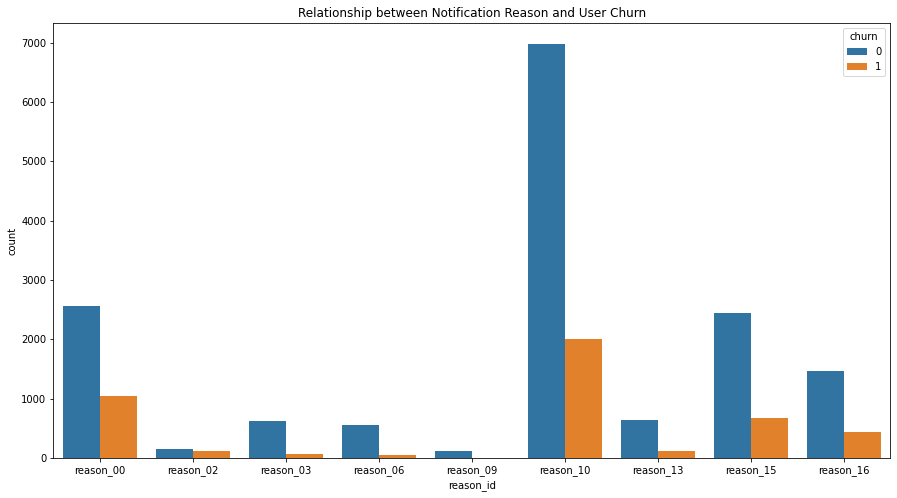

In [55]:
plt.figure(figsize=(15,8))
sns.countplot(x="reason_id", hue="churn", data=notifs_churn_users).set_title('Relationship between Notification Reason and User Churn');

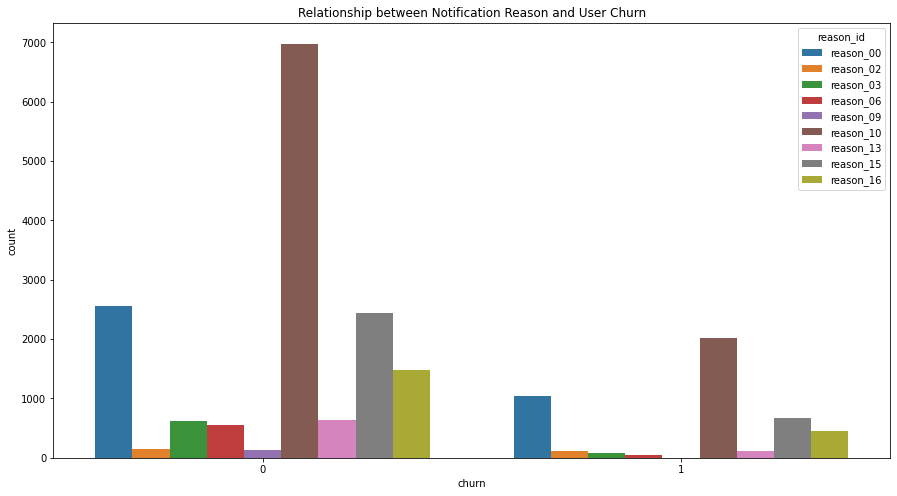

In [56]:
plt.figure(figsize=(15,8))
sns.countplot(x="churn", hue="reason_id", data=notifs_churn_users).set_title('Relationship between Notification Reason and User Churn');

In [57]:
notif_reason = pd.read_csv('../data/reason_type.csv')
notif_reason

,reason_id,reason_name
0,reason_00,REENGAGEMENT_ACTIVE_FUNDS
1,reason_01,PUMPKIN_PAYMENT_NOTIFICATION
2,reason_02,NO_INITIAL_CARD_USE
3,reason_03,ENGAGEMENT_SPLIT_BILL_RESTAURANT
4,reason_04,METAL_RESERVE_PLAN
5,reason_05,ONBOARDING_TIPS_ACTIVATED_USERS
6,reason_06,MADE_MONEY_REQUEST_NOT_SPLIT_BILL
7,reason_07,PREMIUM_ENGAGEMENT_INACTIVE_CARD
8,reason_08,NO_INITIAL_CARD_ORDER
9,reason_09,PREMIUM_ENGAGEMENT_FEES_SAVED


In [58]:
pd.crosstab(notifs_churn_users['reason_id'], notifs_churn_users['churn'])

churn,0,1
reason_id,,
reason_00,2564,1045
reason_02,147,111
reason_03,625,73
reason_06,556,54
reason_09,123,3
reason_10,6978,2011
reason_13,633,114
reason_15,2436,677
reason_16,1471,444


In [59]:
pd.crosstab(notifs_churn_users['reason_id'], notifs_churn_users['churn'], normalize='index')

churn,0,1
reason_id,,
reason_00,0.710446,0.289554
reason_02,0.569767,0.430233
reason_03,0.895415,0.104585
reason_06,0.911475,0.088525
reason_09,0.976190,0.023810
reason_10,0.776282,0.223718
reason_13,0.847390,0.152610
reason_15,0.782525,0.217475
reason_16,0.768146,0.231854


### Marketing Channel

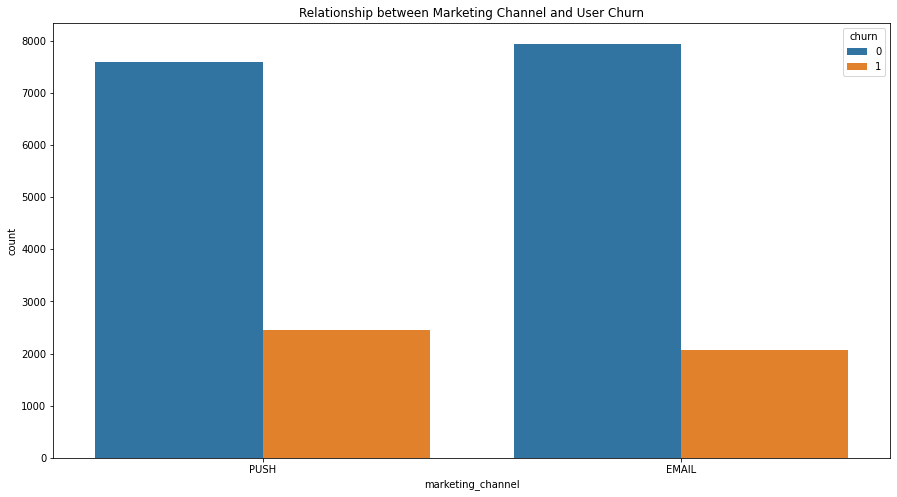

In [60]:
plt.figure(figsize=(15,8))
sns.countplot(x="marketing_channel", hue="churn", data=notifs_churn_users).set_title('Relationship between Marketing Channel and User Churn');

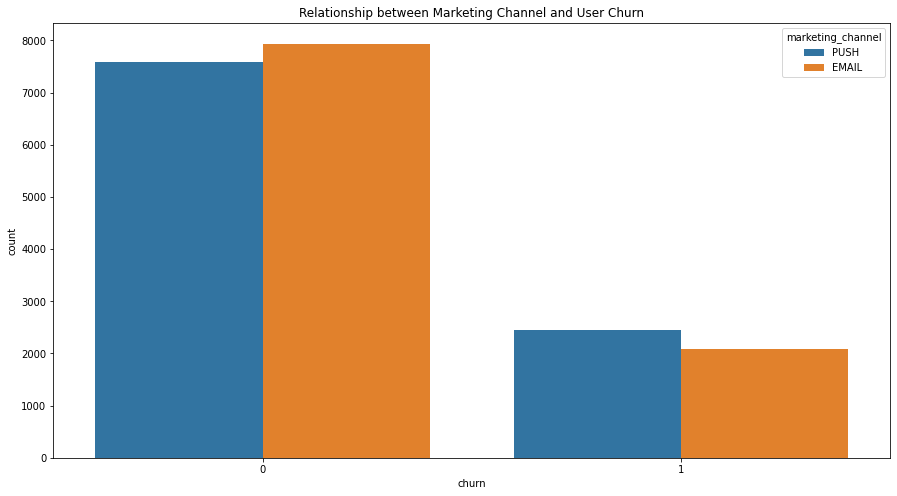

In [61]:
plt.figure(figsize=(15,8))
sns.countplot(x="churn", hue="marketing_channel", data=notifs_churn_users).set_title('Relationship between Marketing Channel and User Churn');

In [62]:
pd.crosstab(notifs_churn_users['marketing_channel'], notifs_churn_users['churn'])

churn,0,1
marketing_channel,,
EMAIL,7939,2076
PUSH,7594,2456


In [63]:
pd.crosstab(notifs_churn_users['marketing_channel'], notifs_churn_users['churn'], normalize='index')

churn,0,1
marketing_channel,,
EMAIL,0.792711,0.207289
PUSH,0.755622,0.244378


### Notification Status

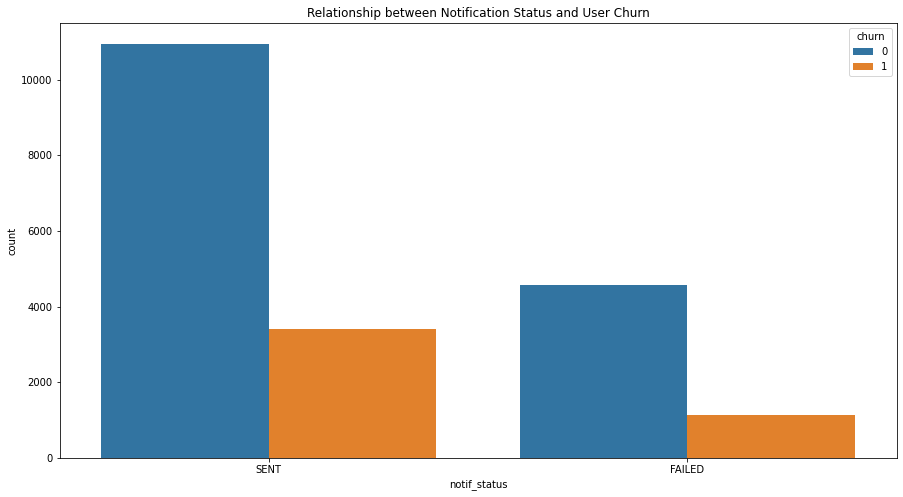

In [64]:
plt.figure(figsize=(15,8))
sns.countplot(x="notif_status", hue="churn", data=notifs_churn_users).set_title('Relationship between Notification Status and User Churn');

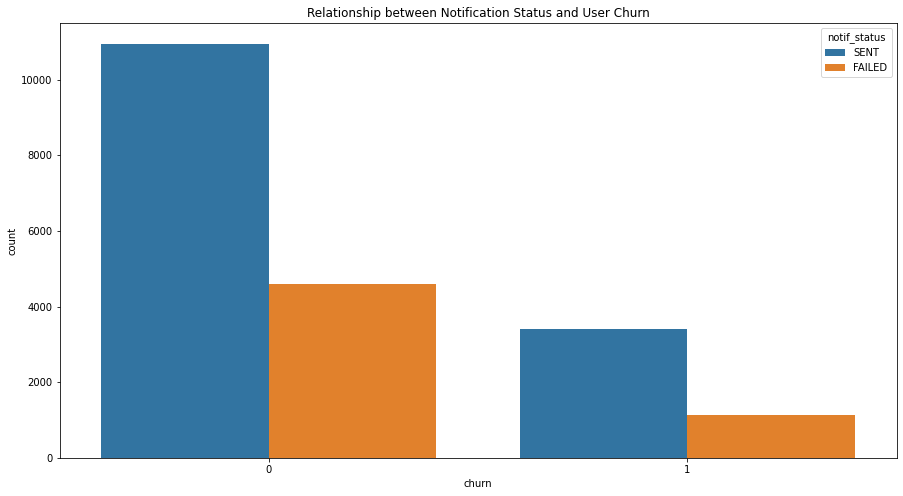

In [65]:
plt.figure(figsize=(15,8))
sns.countplot(x="churn", hue="notif_status", data=notifs_churn_users).set_title('Relationship between Notification Status and User Churn');

In [66]:
pd.crosstab(notifs_churn_users['notif_status'], notifs_churn_users['churn'])

churn,0,1
notif_status,,
FAILED,4583,1128
SENT,10950,3404


In [67]:
pd.crosstab(notifs_churn_users['notif_status'], notifs_churn_users['churn'], normalize='index')

churn,0,1
notif_status,,
FAILED,0.802486,0.197514
SENT,0.762854,0.237146


## Transaction

In [68]:
trans_status = trans_df.loc[(trans_df.user_id.isin(trans_active_user.index)) & (trans_df.record_date > day1) \
                            & ((trans_df.record_date <= cut_day)), :]
trans_status_users = pd.merge(trans_status,trans_user['churn'], how='inner', on='user_id')
trans_status_users['churn'] = trans_status_users['churn'].astype('category')
trans_status_users['cardholderpresence'].fillna('UNKNOWN')
trans_status_users.head()

,record_date,user_id,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id,churn
0,2020-03-19 06:15:59.537000+00:00,user_1652,FALSE,15.50,transaction_1,COMPLETED,type_1,0
1,2020-03-18 18:53:41.323000+00:00,user_1652,FALSE,43.40,transaction_2,COMPLETED,type_1,0
2,2020-03-22 14:20:01.513000+00:00,user_1652,NaN,10043.01,transaction_3,COMPLETED,type_0,0
3,2020-03-17 17:57:06.816000+00:00,user_1652,FALSE,10.44,transaction_6,COMPLETED,type_1,0
4,2020-03-17 21:22:28.723000+00:00,user_1652,FALSE,20.83,transaction_7,COMPLETED,type_1,0


In [69]:
trans_status_users.describe(include='all')

/Users/kongbinxuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,record_date,user_id,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id,churn
count,270948,270948,152350,2.709480e+05,270948,270948,270948,270948.0
unique,270891,6685,3,NaN,270872,6,10,2.0
top,2020-03-22 15:07:13.613000+00:00,user_157,FALSE,NaN,transaction_42020,COMPLETED,type_1,0.0
freq,2,776,118727,NaN,2,242771,144899,256494.0
first,2020-01-01 00:00:06.928000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-03-30 23:59:23.326000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1.816626e+05,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,7.190816e+07,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,1.750000e+00,NaN,NaN,NaN,NaN


In [70]:
trans_status_users.loc[trans_status_users['churn'] == 0].describe(include='all')

/Users/kongbinxuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,record_date,user_id,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id,churn
count,256494,256494,143273,2.564940e+05,256494,256494,256494,256494.0
unique,256439,5132,3,NaN,256427,6,10,1.0
top,2020-01-15 07:32:43.037000+00:00,user_157,FALSE,NaN,transaction_820206,COMPLETED,type_1,0.0
freq,2,776,111065,NaN,2,230646,136635,256494.0
first,2020-01-01 00:00:06.928000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-03-30 23:59:23.326000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1.918932e+05,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,7.390648e+07,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,1.690000e+00,NaN,NaN,NaN,NaN


In [71]:
trans_status_users.loc[trans_status_users['churn'] == 1].describe(include='all')

/Users/kongbinxuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,record_date,user_id,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id,churn
count,14454,14454,9077,14454.000000,14454,14454,14454,14454.0
unique,14452,1553,3,NaN,14453,6,10,1.0
top,2020-02-16 20:16:40.126000+00:00,user_521,FALSE,NaN,transaction_20200,COMPLETED,type_1,1.0
freq,2,161,7662,NaN,2,12125,8264,14454.0
first,2020-01-01 00:05:52.518000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-03-30 23:46:18.507000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,115.122969,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1741.490146,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,4.440000,NaN,NaN,NaN,NaN


### Cardholder Presence

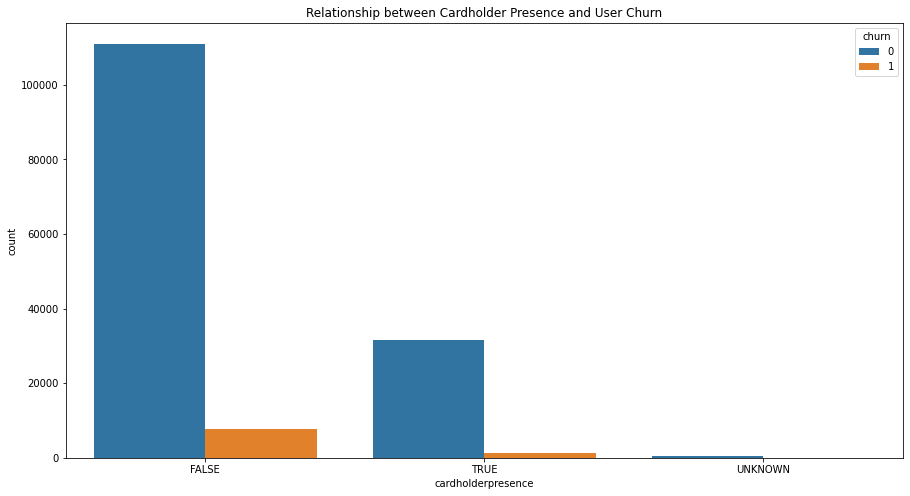

In [72]:
plt.figure(figsize=(15,8))
sns.countplot(x="cardholderpresence", hue="churn", data=trans_status_users).\
           set_title('Relationship between Cardholder Presence and User Churn')
plt.yscale='log';

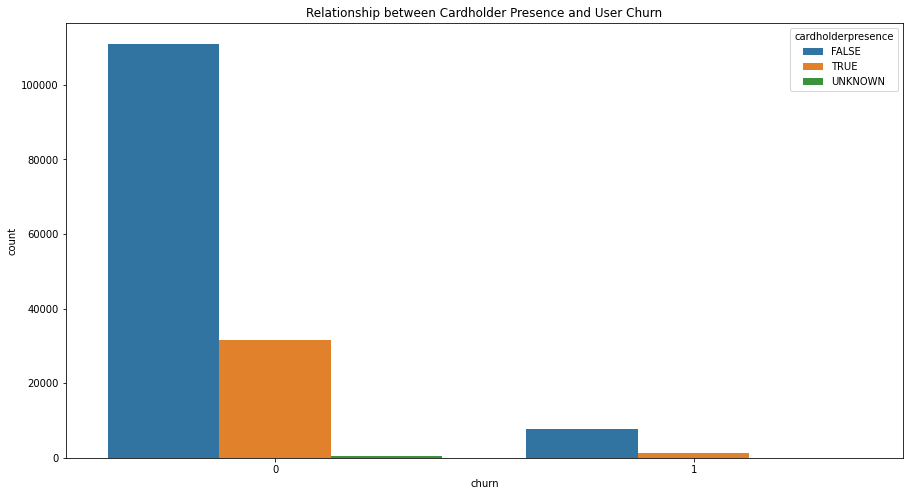

In [73]:
plt.figure(figsize=(15,8))
sns.countplot(x="churn", hue="cardholderpresence", data=trans_status_users).\
           set_title('Relationship between Cardholder Presence and User Churn')
plt.yscale='log';

In [74]:
pd.crosstab(trans_status_users['cardholderpresence'], trans_status_users['churn'])

churn,0,1
cardholderpresence,,
FALSE,111065,7662
TRUE,31706,1380
UNKNOWN,502,35


In [75]:
pd.crosstab(trans_status_users['cardholderpresence'], trans_status_users['churn'], normalize='index')

churn,0,1
cardholderpresence,,
FALSE,0.935465,0.064535
TRUE,0.958291,0.041709
UNKNOWN,0.934823,0.065177


### Transaction State

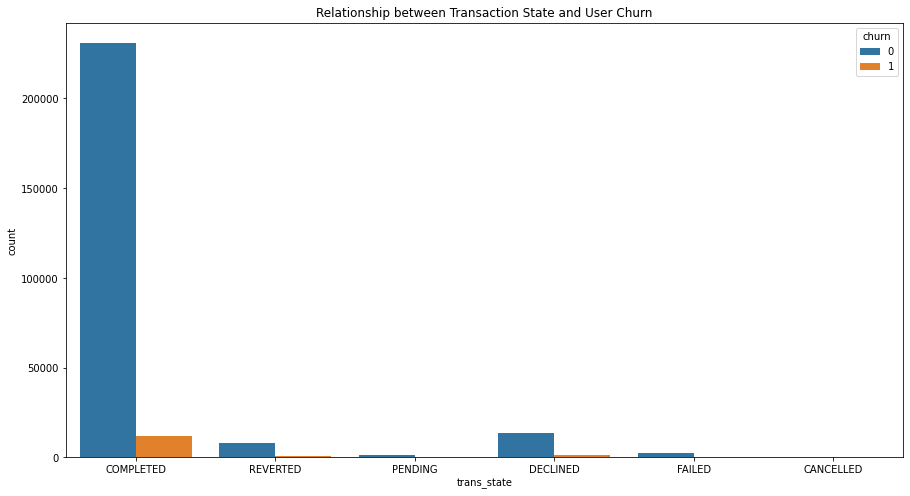

In [76]:
plt.figure(figsize=(15,8))
sns.countplot(x="trans_state", hue="churn", data=trans_status_users).\
           set_title('Relationship between Transaction State and User Churn')
plt.yscale='log';

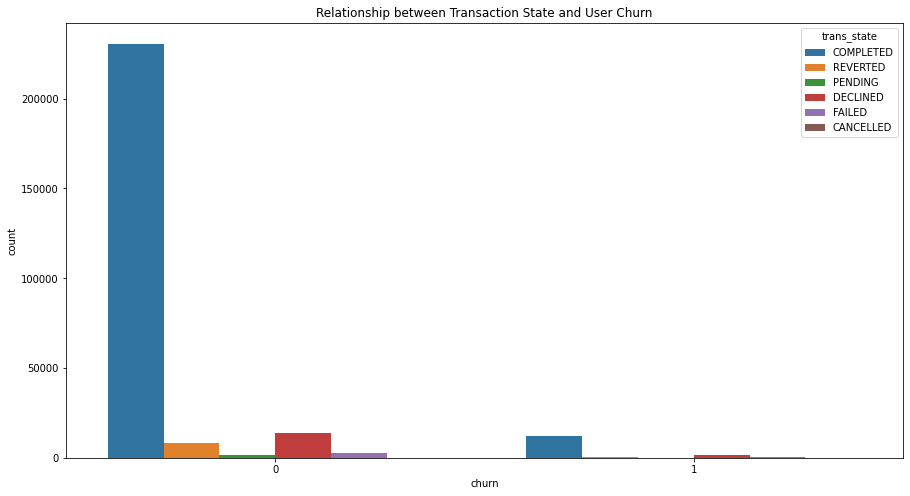

In [77]:
plt.figure(figsize=(15,8))
sns.countplot(x="churn", hue="trans_state", data=trans_status_users).\
           set_title('Relationship between Transaction State and User Churn')
plt.yscale='log';

In [78]:
pd.crosstab(trans_status_users['trans_state'], trans_status_users['churn'])

churn,0,1
trans_state,,
CANCELLED,112,8
COMPLETED,230646,12125
DECLINED,13677,1334
FAILED,2651,266
PENDING,1346,55
REVERTED,8062,666


In [79]:
pd.crosstab(trans_status_users['trans_state'], trans_status_users['churn'], normalize='index')

churn,0,1
trans_state,,
CANCELLED,0.933333,0.066667
COMPLETED,0.950056,0.049944
DECLINED,0.911132,0.088868
FAILED,0.908810,0.091190
PENDING,0.960742,0.039258
REVERTED,0.923694,0.076306


### Transaction Type

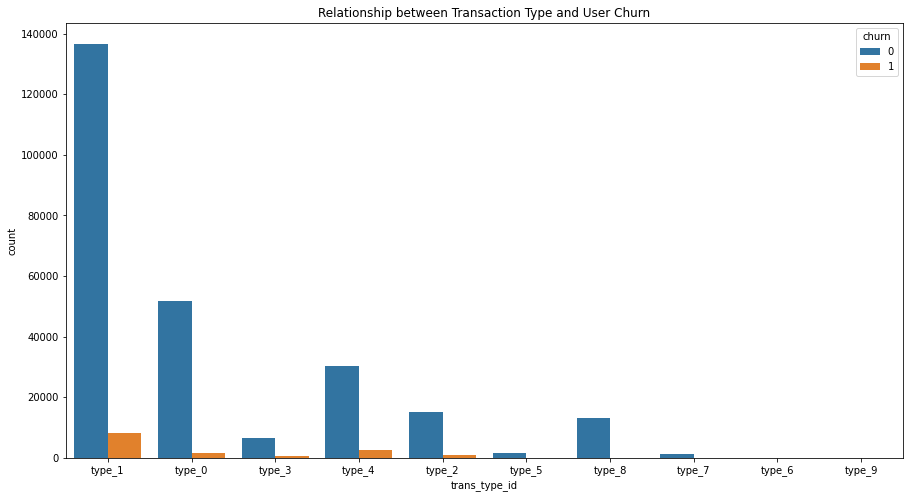

In [80]:
plt.figure(figsize=(15,8))
sns.countplot(x="trans_type_id", hue="churn", data=trans_status_users).\
           set_title('Relationship between Transaction Type and User Churn')
plt.yscale='log';

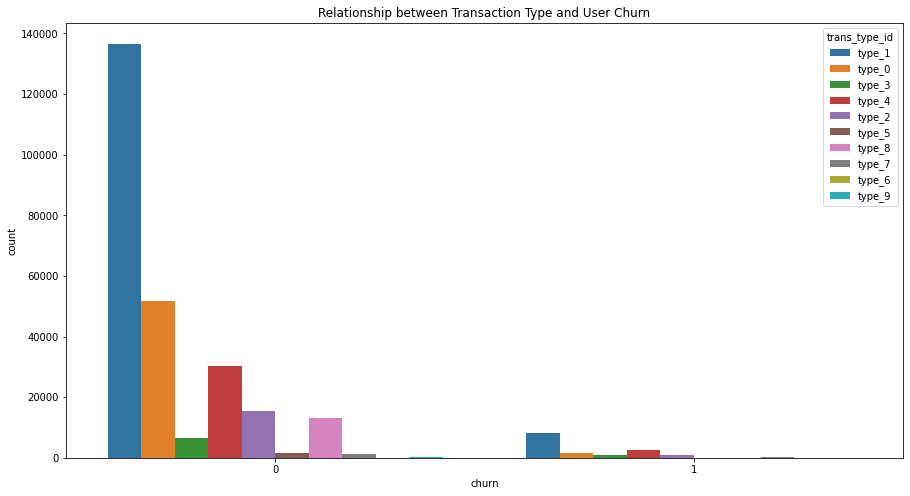

In [81]:
plt.figure(figsize=(15,8))
sns.countplot(x="churn", hue="trans_type_id", data=trans_status_users).\
           set_title('Relationship between Transaction Type and User Churn')
plt.yscale='log';

In [82]:
trans_type = pd.read_csv('../data/trans_type.csv')
trans_type

,trans_type_id,trans_type_name
0,type_0,TRANSFER
1,type_1,CARD_PAYMENT
2,type_2,EXCHANGE
3,type_3,ATM
4,type_4,TOPUP
5,type_5,CARD_REFUND
6,type_6,REFUND
7,type_7,FEE
8,type_8,CASHBACK
9,type_9,TAX


In [83]:
pd.crosstab(trans_status_users['trans_type_id'], trans_status_users['churn'])

churn,0,1
trans_type_id,,
type_0,51633,1545
type_1,136635,8264
type_2,15282,1058
type_3,6600,813
type_4,30187,2476
type_5,1528,75
type_6,88,5
type_7,1351,156
type_8,13043,59


In [84]:
pd.crosstab(trans_status_users['trans_type_id'], trans_status_users['churn'], normalize='index')

churn,0,1
trans_type_id,,
type_0,0.970947,0.029053
type_1,0.942967,0.057033
type_2,0.935251,0.064749
type_3,0.890328,0.109672
type_4,0.924196,0.075804
type_5,0.953213,0.046787
type_6,0.946237,0.053763
type_7,0.896483,0.103517
type_8,0.995497,0.004503
